O3 농도 예측 모델의 학습 및 모델 예측 테스트 코드

VER: 
    
    v5.2

SETUP:

    In[NOx, VOC, 'VOC*NOx', 'NH3', 'PM25']
    Out[pred. O3]

STRUCTURE:

    CMAQ U-Net (w/o Conditional)

    model = build_model(
        ..., 
        hidden_size=[128, 96],
        hidden_depth=5,
        ...,
        in_filters=10,
        ...
    )

PARAMETER:

    EPOCH = 1000
    Lr = 1e-3
    test_split = 0.4

In [1]:
# Import
import os
import sys
sys.path.append('/home/user/workdir/CMAQ_Emulator/main')

import numpy as np
import pandas as pd
import netCDF4 as nc
from netCDF4 import Dataset

from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import r2_score

import geopandas as gpd
from shapely.geometry import Point
import matplotlib as mpl
import matplotlib.pyplot as plt

2025-02-28 14:19:39.685762: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-28 14:19:39.716823: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-28 14:19:39.716854: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-28 14:19:39.716877: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-28 14:19:39.723005: I tensorflow/core/platform/cpu_feature_g

# Training

In [2]:
dataset_2013 = pd.read_csv('/home/user/workdir/CMAQ_Emulator/main/resources/ctrl/dataset_for_o3_v5.1.csv')

ctrl_data = pd.concat([dataset_2013], axis=0)
ctrl_data = ctrl_data.reset_index(drop=True).values
emis_data = ctrl_data[:, :17*5]
label_path_2013 = '/home/user/workdir/CMAQ_Emulator/main/datasets/concentration/2013'
label_path = []
for i in range(1, 120): 
    label_path.append(os.path.join(label_path_2013, '1.00', f'ACONC.{i}'))
label_data = []
for path in label_path:
    with nc.Dataset(path) as f:
        label_data.append(f.variables['O3'][:].data.squeeze())  # ncf 파일 내 목적변수를 지정 
label_data = np.array(label_data).reshape(len(label_data), 82, 67, 1)

In [3]:
from src.model.cmaqnet_unet import build_model

model_path = '/home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model'  # 모델 저장 경로

epochs = 1000  # 훈련 반복 횟수
batch_size = 32  # 배치 크기
test_split = 0.4  # 테스트 데이터 비율 (50%)
random_seed = 42  # 랜덤 시드

X_emis_train, X_emis_test, y_train, y_test = train_test_split(emis_data, label_data, test_size=test_split, random_state=random_seed)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPUs")
    except RuntimeError as e:
        print(e)

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = build_model(
        ctrl_dim=17*5,
        out_channel=1,
        hidden_size=[128, 96],
        hidden_depth=5,
        in_filters=10,
        kernel_size=3,
        activation='silu',
        dropout=0.0,
        use_abs=True
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss=tf.keras.losses.MeanAbsoluteError(),
    )
    
# define callback
def scheduler(epoch, lr):
    # if epoch <= 1000: return 2.5e-3
    if epoch <= 1000: return 1e-3
    else: return 1e-4
callback_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

callback_ckpt = tf.keras.callbacks.ModelCheckpoint(
    filepath='/home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-{epoch:02d}-{val_loss:.4f}',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch')

history = model.fit(
    x=[X_emis_train],   # 입력 데이터 (지역 별 배출량, 경계 조건 값)
    y=y_train,                                          # 입력 데이터의 Label 값 (netCDF에서 PM2.5 값)
    epochs=epochs,
    batch_size=batch_size,
    validation_data=[[X_emis_test], y_test], # test 데이터
    callbacks=[callback_lr, callback_ckpt])
model.save(model_path)

def plot_loss(history):
    plt.figure(figsize=(10, 6))
    
    # 학습 손실
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    # 검증 손실
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
''' 16min '''

Memory growth enabled for GPUs
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


2025-02-28 14:19:42.433313: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15362 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:19:00.0, compute capability: 8.6
2025-02-28 14:19:42.434971: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 15362 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1a:00.0, compute capability: 8.6
2025-02-28 14:19:42.436479: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 15362 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:67:00.0, compute capability: 8.6
2025-02-28 14:19:42.437945: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 15293 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 3090

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

2025-02-28 14:20:07.199945: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-02-28 14:20:07.219346: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-02-28 14:20:07.241347: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-02-28 14:20:07.265863: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-02-28 14:20:09.990604: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f0629582df0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-02-28 14:20:09.990654: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-02-28 14:20:09.990669: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-02-28 14:20:09.99067

3/3 [==============================] - ETA: 0s - loss: 0.0889 INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-01-0.0369/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-01-0.0369/assets


3/3 [==============================] - 44s 7s/step - loss: 0.0889 - val_loss: 0.0369 - lr: 0.0010
Epoch 2/1000
3/3 [==============================] - 0s 184ms/step - loss: 0.0316 - val_loss: 0.0394 - lr: 0.0010
Epoch 3/1000
3/3 [==============================] - 0s 196ms/step - loss: 0.0184 - val_loss: 0.0387 - lr: 0.0010
Epoch 4/1000
3/3 [==============================] - 0s 201ms/step - loss: 0.0149 - val_loss: 0.0392 - lr: 0.0010
Epoch 5/1000
3/3 [==============================] - 0s 222ms/step - loss: 0.0138 - val_loss: 0.0385 - lr: 0.0010
Epoch 6/1000
3/3 [==============================] - 0s 222ms/step - loss: 0.0118 - val_loss: 0.0395 - lr: 0.0010
Epoch 7/1000
3/3 [==============================] - 0s 205ms/step - loss: 0.0116 - val_loss: 0.0390 - lr: 0.0010
Epoch 8/1000
3/3 [==============================] - 0s 179ms/step - loss: 0.0096 - val_loss: 0.0398 - lr: 0.0010
Epoch 9/1000
3/3 [==============================] - 0s 195ms/step - loss: 0.0093 - val_loss: 0.0394 - lr: 0.001

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-23-0.0359/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0057 - val_loss: 0.0359 - lr: 0.0010
Epoch 24/1000
3/3 [==============================] - ETA: 0s - loss: 0.0055INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-24-0.0352/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-24-0.0352/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0055 - val_loss: 0.0352 - lr: 0.0010
Epoch 25/1000
3/3 [==============================] - ETA: 0s - loss: 0.0061INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-25-0.0343/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-25-0.0343/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0061 - val_loss: 0.0343 - lr: 0.0010
Epoch 26/1000
3/3 [==============================] - ETA: 0s - loss: 0.0065INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-26-0.0330/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-26-0.0330/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0065 - val_loss: 0.0330 - lr: 0.0010
Epoch 27/1000
3/3 [==============================] - ETA: 0s - loss: 0.0057INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-27-0.0321/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-27-0.0321/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0057 - val_loss: 0.0321 - lr: 0.0010
Epoch 28/1000
3/3 [==============================] - ETA: 0s - loss: 0.0065INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-28-0.0291/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-28-0.0291/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0065 - val_loss: 0.0291 - lr: 0.0010
Epoch 29/1000
3/3 [==============================] - ETA: 0s - loss: 0.0060INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-29-0.0286/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-29-0.0286/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0060 - val_loss: 0.0286 - lr: 0.0010
Epoch 30/1000
3/3 [==============================] - 0s 219ms/step - loss: 0.0058 - val_loss: 0.0306 - lr: 0.0010
Epoch 31/1000
3/3 [==============================] - 0s 212ms/step - loss: 0.0060 - val_loss: 0.0289 - lr: 0.0010
Epoch 32/1000
3/3 [==============================] - 0s 225ms/step - loss: 0.0055 - val_loss: 0.0300 - lr: 0.0010
Epoch 33/1000
3/3 [==============================] - 0s 184ms/step - loss: 0.0051 - val_loss: 0.0310 - lr: 0.0010
Epoch 34/1000
3/3 [==============================] - 0s 195ms/step - loss: 0.0051 - val_loss: 0.0313 - lr: 0.0010
Epoch 35/1000
3/3 [==============================] - 0s 183ms/step - loss: 0.0048 - val_loss: 0.0304 - lr: 0.0010
Epoch 36/1000
3/3 [==============================] - 0s 179ms/step - loss: 0.0052 - val_loss: 0.0297 - lr: 0.0010
Epoch 37/1000
3/3 [==============================] - 1s 240ms/step - loss: 0.0046 - val_loss: 0.0294 - lr

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-38-0.0286/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0047 - val_loss: 0.0286 - lr: 0.0010
Epoch 39/1000
3/3 [==============================] - ETA: 0s - loss: 0.0042INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-39-0.0277/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-39-0.0277/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0042 - val_loss: 0.0277 - lr: 0.0010
Epoch 40/1000
3/3 [==============================] - 0s 194ms/step - loss: 0.0044 - val_loss: 0.0277 - lr: 0.0010
Epoch 41/1000
3/3 [==============================] - ETA: 0s - loss: 0.0054INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-41-0.0248/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-41-0.0248/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0054 - val_loss: 0.0248 - lr: 0.0010
Epoch 42/1000
3/3 [==============================] - ETA: 0s - loss: 0.0053INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-42-0.0246/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-42-0.0246/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0053 - val_loss: 0.0246 - lr: 0.0010
Epoch 43/1000
3/3 [==============================] - 0s 209ms/step - loss: 0.0046 - val_loss: 0.0253 - lr: 0.0010
Epoch 44/1000
3/3 [==============================] - 0s 192ms/step - loss: 0.0046 - val_loss: 0.0249 - lr: 0.0010
Epoch 45/1000
3/3 [==============================] - ETA: 0s - loss: 0.0050INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-45-0.0231/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-45-0.0231/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0050 - val_loss: 0.0231 - lr: 0.0010
Epoch 46/1000
3/3 [==============================] - ETA: 0s - loss: 0.0048INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-46-0.0228/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-46-0.0228/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0048 - val_loss: 0.0228 - lr: 0.0010
Epoch 47/1000
3/3 [==============================] - 0s 204ms/step - loss: 0.0043 - val_loss: 0.0240 - lr: 0.0010
Epoch 48/1000
3/3 [==============================] - 0s 185ms/step - loss: 0.0045 - val_loss: 0.0239 - lr: 0.0010
Epoch 49/1000
3/3 [==============================] - ETA: 0s - loss: 0.0047INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-49-0.0219/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-49-0.0219/assets


3/3 [==============================] - 10s 5s/step - loss: 0.0047 - val_loss: 0.0219 - lr: 0.0010
Epoch 50/1000
3/3 [==============================] - ETA: 0s - loss: 0.0046INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-50-0.0214/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-50-0.0214/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0046 - val_loss: 0.0214 - lr: 0.0010
Epoch 51/1000
3/3 [==============================] - 0s 193ms/step - loss: 0.0044 - val_loss: 0.0225 - lr: 0.0010
Epoch 52/1000
3/3 [==============================] - 0s 193ms/step - loss: 0.0042 - val_loss: 0.0221 - lr: 0.0010
Epoch 53/1000
3/3 [==============================] - ETA: 0s - loss: 0.0044INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-53-0.0197/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-53-0.0197/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0044 - val_loss: 0.0197 - lr: 0.0010
Epoch 54/1000
3/3 [==============================] - ETA: 0s - loss: 0.0042INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-54-0.0195/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-54-0.0195/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0042 - val_loss: 0.0195 - lr: 0.0010
Epoch 55/1000
3/3 [==============================] - 0s 203ms/step - loss: 0.0040 - val_loss: 0.0203 - lr: 0.0010
Epoch 56/1000
3/3 [==============================] - 0s 193ms/step - loss: 0.0041 - val_loss: 0.0205 - lr: 0.0010
Epoch 57/1000
3/3 [==============================] - ETA: 0s - loss: 0.0042INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-57-0.0183/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-57-0.0183/assets


3/3 [==============================] - 10s 5s/step - loss: 0.0042 - val_loss: 0.0183 - lr: 0.0010
Epoch 58/1000
3/3 [==============================] - ETA: 0s - loss: 0.0039INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-58-0.0181/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-58-0.0181/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0039 - val_loss: 0.0181 - lr: 0.0010
Epoch 59/1000
3/3 [==============================] - 0s 187ms/step - loss: 0.0041 - val_loss: 0.0184 - lr: 0.0010
Epoch 60/1000
3/3 [==============================] - 0s 210ms/step - loss: 0.0038 - val_loss: 0.0187 - lr: 0.0010
Epoch 61/1000
3/3 [==============================] - ETA: 0s - loss: 0.0045INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-61-0.0160/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-61-0.0160/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0045 - val_loss: 0.0160 - lr: 0.0010
Epoch 62/1000
3/3 [==============================] - 1s 231ms/step - loss: 0.0037 - val_loss: 0.0164 - lr: 0.0010
Epoch 63/1000
3/3 [==============================] - 0s 200ms/step - loss: 0.0034 - val_loss: 0.0171 - lr: 0.0010
Epoch 64/1000
3/3 [==============================] - ETA: 0s - loss: 0.0037INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-64-0.0156/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-64-0.0156/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0037 - val_loss: 0.0156 - lr: 0.0010
Epoch 65/1000
3/3 [==============================] - ETA: 0s - loss: 0.0040INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-65-0.0156/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-65-0.0156/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0040 - val_loss: 0.0156 - lr: 0.0010
Epoch 66/1000
3/3 [==============================] - 0s 206ms/step - loss: 0.0036 - val_loss: 0.0169 - lr: 0.0010
Epoch 67/1000
3/3 [==============================] - 0s 197ms/step - loss: 0.0037 - val_loss: 0.0159 - lr: 0.0010
Epoch 68/1000
3/3 [==============================] - 0s 203ms/step - loss: 0.0034 - val_loss: 0.0157 - lr: 0.0010
Epoch 69/1000
3/3 [==============================] - ETA: 0s - loss: 0.0032INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-69-0.0155/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-69-0.0155/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0032 - val_loss: 0.0155 - lr: 0.0010
Epoch 70/1000
3/3 [==============================] - ETA: 0s - loss: 0.0032INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-70-0.0147/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-70-0.0147/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0032 - val_loss: 0.0147 - lr: 0.0010
Epoch 71/1000
3/3 [==============================] - 0s 225ms/step - loss: 0.0030 - val_loss: 0.0155 - lr: 0.0010
Epoch 72/1000
3/3 [==============================] - 0s 193ms/step - loss: 0.0033 - val_loss: 0.0148 - lr: 0.0010
Epoch 73/1000
3/3 [==============================] - ETA: 0s - loss: 0.0031INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-73-0.0147/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-73-0.0147/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0031 - val_loss: 0.0147 - lr: 0.0010
Epoch 74/1000
3/3 [==============================] - ETA: 0s - loss: 0.0032INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-74-0.0139/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-74-0.0139/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0032 - val_loss: 0.0139 - lr: 0.0010
Epoch 75/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0030INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-75-0.0127/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-75-0.0127/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0031 - val_loss: 0.0127 - lr: 0.0010
Epoch 76/1000
3/3 [==============================] - ETA: 0s - loss: 0.0033INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-76-0.0121/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-76-0.0121/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0033 - val_loss: 0.0121 - lr: 0.0010
Epoch 77/1000
3/3 [==============================] - 0s 223ms/step - loss: 0.0030 - val_loss: 0.0124 - lr: 0.0010
Epoch 78/1000
3/3 [==============================] - 0s 189ms/step - loss: 0.0027 - val_loss: 0.0127 - lr: 0.0010
Epoch 79/1000
3/3 [==============================] - 0s 188ms/step - loss: 0.0030 - val_loss: 0.0135 - lr: 0.0010
Epoch 80/1000
3/3 [==============================] - ETA: 0s - loss: 0.0038INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-80-0.0102/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-80-0.0102/assets


3/3 [==============================] - 10s 5s/step - loss: 0.0038 - val_loss: 0.0102 - lr: 0.0010
Epoch 81/1000
3/3 [==============================] - 0s 188ms/step - loss: 0.0038 - val_loss: 0.0112 - lr: 0.0010
Epoch 82/1000
3/3 [==============================] - 0s 222ms/step - loss: 0.0032 - val_loss: 0.0113 - lr: 0.0010
Epoch 83/1000
3/3 [==============================] - 1s 221ms/step - loss: 0.0030 - val_loss: 0.0121 - lr: 0.0010
Epoch 84/1000
3/3 [==============================] - ETA: 0s - loss: 0.0035INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-84-0.0097/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-84-0.0097/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0035 - val_loss: 0.0097 - lr: 0.0010
Epoch 85/1000
3/3 [==============================] - ETA: 0s - loss: 0.0035INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-85-0.0091/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-85-0.0091/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0035 - val_loss: 0.0091 - lr: 0.0010
Epoch 86/1000
3/3 [==============================] - 0s 195ms/step - loss: 0.0034 - val_loss: 0.0108 - lr: 0.0010
Epoch 87/1000
3/3 [==============================] - 0s 211ms/step - loss: 0.0038 - val_loss: 0.0104 - lr: 0.0010
Epoch 88/1000
3/3 [==============================] - 0s 202ms/step - loss: 0.0030 - val_loss: 0.0093 - lr: 0.0010
Epoch 89/1000
3/3 [==============================] - 0s 206ms/step - loss: 0.0029 - val_loss: 0.0094 - lr: 0.0010
Epoch 90/1000
3/3 [==============================] - 1s 247ms/step - loss: 0.0027 - val_loss: 0.0101 - lr: 0.0010
Epoch 91/1000
3/3 [==============================] - 0s 219ms/step - loss: 0.0028 - val_loss: 0.0092 - lr: 0.0010
Epoch 92/1000
3/3 [==============================] - 0s 189ms/step - loss: 0.0026 - val_loss: 0.0098 - lr: 0.0010
Epoch 93/1000
3/3 [==============================] - ETA: 0s - loss: 0.0026INFO:tensorflow:Assets written

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-93-0.0090/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0026 - val_loss: 0.0090 - lr: 0.0010
Epoch 94/1000
3/3 [==============================] - 0s 222ms/step - loss: 0.0025 - val_loss: 0.0097 - lr: 0.0010
Epoch 95/1000
3/3 [==============================] - ETA: 0s - loss: 0.0028INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-95-0.0087/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-95-0.0087/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0028 - val_loss: 0.0087 - lr: 0.0010
Epoch 96/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0024INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-96-0.0083/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-96-0.0083/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0025 - val_loss: 0.0083 - lr: 0.0010
Epoch 97/1000
3/3 [==============================] - ETA: 0s - loss: 0.0023INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-97-0.0079/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-97-0.0079/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0023 - val_loss: 0.0079 - lr: 0.0010
Epoch 98/1000
3/3 [==============================] - 0s 195ms/step - loss: 0.0024 - val_loss: 0.0080 - lr: 0.0010
Epoch 99/1000
3/3 [==============================] - 0s 216ms/step - loss: 0.0027 - val_loss: 0.0090 - lr: 0.0010
Epoch 100/1000
3/3 [==============================] - ETA: 0s - loss: 0.0030INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-100-0.0060/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-100-0.0060/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0030 - val_loss: 0.0060 - lr: 0.0010
Epoch 101/1000
3/3 [==============================] - 0s 203ms/step - loss: 0.0033 - val_loss: 0.0064 - lr: 0.0010
Epoch 102/1000
3/3 [==============================] - 0s 214ms/step - loss: 0.0029 - val_loss: 0.0073 - lr: 0.0010
Epoch 103/1000
3/3 [==============================] - 0s 200ms/step - loss: 0.0027 - val_loss: 0.0078 - lr: 0.0010
Epoch 104/1000
3/3 [==============================] - ETA: 0s - loss: 0.0029INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-104-0.0051/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-104-0.0051/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0029 - val_loss: 0.0051 - lr: 0.0010
Epoch 105/1000
3/3 [==============================] - 1s 233ms/step - loss: 0.0030 - val_loss: 0.0068 - lr: 0.0010
Epoch 106/1000
3/3 [==============================] - 1s 231ms/step - loss: 0.0033 - val_loss: 0.0062 - lr: 0.0010
Epoch 107/1000
3/3 [==============================] - ETA: 0s - loss: 0.0028INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-107-0.0051/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-107-0.0051/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0028 - val_loss: 0.0051 - lr: 0.0010
Epoch 108/1000
3/3 [==============================] - 0s 195ms/step - loss: 0.0024 - val_loss: 0.0055 - lr: 0.0010
Epoch 109/1000
3/3 [==============================] - 0s 197ms/step - loss: 0.0024 - val_loss: 0.0064 - lr: 0.0010
Epoch 110/1000
3/3 [==============================] - 0s 199ms/step - loss: 0.0024 - val_loss: 0.0060 - lr: 0.0010
Epoch 111/1000
3/3 [==============================] - 1s 236ms/step - loss: 0.0020 - val_loss: 0.0063 - lr: 0.0010
Epoch 112/1000
3/3 [==============================] - 0s 211ms/step - loss: 0.0023 - val_loss: 0.0052 - lr: 0.0010
Epoch 113/1000
3/3 [==============================] - ETA: 0s - loss: 0.0024INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-113-0.0042/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-113-0.0042/assets


3/3 [==============================] - 10s 5s/step - loss: 0.0024 - val_loss: 0.0042 - lr: 0.0010
Epoch 114/1000
3/3 [==============================] - 0s 220ms/step - loss: 0.0025 - val_loss: 0.0058 - lr: 0.0010
Epoch 115/1000
3/3 [==============================] - 0s 202ms/step - loss: 0.0027 - val_loss: 0.0056 - lr: 0.0010
Epoch 116/1000
3/3 [==============================] - 0s 208ms/step - loss: 0.0026 - val_loss: 0.0042 - lr: 0.0010
Epoch 117/1000
3/3 [==============================] - 0s 203ms/step - loss: 0.0023 - val_loss: 0.0046 - lr: 0.0010
Epoch 118/1000
3/3 [==============================] - 0s 194ms/step - loss: 0.0018 - val_loss: 0.0050 - lr: 0.0010
Epoch 119/1000
3/3 [==============================] - 0s 187ms/step - loss: 0.0020 - val_loss: 0.0051 - lr: 0.0010
Epoch 120/1000
3/3 [==============================] - 0s 202ms/step - loss: 0.0021 - val_loss: 0.0050 - lr: 0.0010
Epoch 121/1000
3/3 [==============================] - ETA: 0s - loss: 0.0022INFO:tensorflow:Asset

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-121-0.0038/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0022 - val_loss: 0.0038 - lr: 0.0010
Epoch 122/1000
3/3 [==============================] - ETA: 0s - loss: 0.0024INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-122-0.0034/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-122-0.0034/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0024 - val_loss: 0.0034 - lr: 0.0010
Epoch 123/1000
3/3 [==============================] - 0s 196ms/step - loss: 0.0024 - val_loss: 0.0048 - lr: 0.0010
Epoch 124/1000
3/3 [==============================] - 0s 194ms/step - loss: 0.0022 - val_loss: 0.0044 - lr: 0.0010
Epoch 125/1000
3/3 [==============================] - 0s 216ms/step - loss: 0.0019 - val_loss: 0.0036 - lr: 0.0010
Epoch 126/1000
3/3 [==============================] - 0s 207ms/step - loss: 0.0021 - val_loss: 0.0035 - lr: 0.0010
Epoch 127/1000
3/3 [==============================] - 1s 229ms/step - loss: 0.0024 - val_loss: 0.0044 - lr: 0.0010
Epoch 128/1000
3/3 [==============================] - 0s 191ms/step - loss: 0.0021 - val_loss: 0.0045 - lr: 0.0010
Epoch 129/1000
3/3 [==============================] - ETA: 0s - loss: 0.0021INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-129-0.0033/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-129-0.0033/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0021 - val_loss: 0.0033 - lr: 0.0010
Epoch 130/1000
3/3 [==============================] - ETA: 0s - loss: 0.0021INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-130-0.0032/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-130-0.0032/assets


3/3 [==============================] - 10s 5s/step - loss: 0.0021 - val_loss: 0.0032 - lr: 0.0010
Epoch 131/1000
3/3 [==============================] - 0s 219ms/step - loss: 0.0021 - val_loss: 0.0044 - lr: 0.0010
Epoch 132/1000
3/3 [==============================] - 0s 218ms/step - loss: 0.0021 - val_loss: 0.0045 - lr: 0.0010
Epoch 133/1000
3/3 [==============================] - 0s 208ms/step - loss: 0.0021 - val_loss: 0.0036 - lr: 0.0010
Epoch 134/1000
3/3 [==============================] - 0s 198ms/step - loss: 0.0020 - val_loss: 0.0036 - lr: 0.0010
Epoch 135/1000
3/3 [==============================] - 0s 183ms/step - loss: 0.0019 - val_loss: 0.0047 - lr: 0.0010
Epoch 136/1000
3/3 [==============================] - 0s 196ms/step - loss: 0.0018 - val_loss: 0.0046 - lr: 0.0010
Epoch 137/1000
3/3 [==============================] - 0s 207ms/step - loss: 0.0019 - val_loss: 0.0039 - lr: 0.0010
Epoch 138/1000
3/3 [==============================] - 0s 189ms/step - loss: 0.0020 - val_loss: 0.

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-141-0.0031/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0019 - val_loss: 0.0031 - lr: 0.0010
Epoch 142/1000
3/3 [==============================] - 0s 210ms/step - loss: 0.0020 - val_loss: 0.0033 - lr: 0.0010
Epoch 143/1000
3/3 [==============================] - 0s 210ms/step - loss: 0.0016 - val_loss: 0.0036 - lr: 0.0010
Epoch 144/1000
3/3 [==============================] - 0s 192ms/step - loss: 0.0016 - val_loss: 0.0034 - lr: 0.0010
Epoch 145/1000
3/3 [==============================] - 1s 242ms/step - loss: 0.0015 - val_loss: 0.0034 - lr: 0.0010
Epoch 146/1000
3/3 [==============================] - 0s 184ms/step - loss: 0.0013 - val_loss: 0.0033 - lr: 0.0010
Epoch 147/1000
3/3 [==============================] - 1s 234ms/step - loss: 0.0012 - val_loss: 0.0035 - lr: 0.0010
Epoch 148/1000
3/3 [==============================] - 0s 206ms/step - loss: 0.0016 - val_loss: 0.0044 - lr: 0.0010
Epoch 149/1000
3/3 [==============================] - 0s 201ms/step - loss: 0.0013 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-194-0.0031/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0015 - val_loss: 0.0031 - lr: 0.0010
Epoch 195/1000
3/3 [==============================] - 1s 233ms/step - loss: 0.0015 - val_loss: 0.0032 - lr: 0.0010
Epoch 196/1000
3/3 [==============================] - ETA: 0s - loss: 0.0013INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-196-0.0028/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-196-0.0028/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0013 - val_loss: 0.0028 - lr: 0.0010
Epoch 197/1000
3/3 [==============================] - 0s 212ms/step - loss: 0.0010 - val_loss: 0.0030 - lr: 0.0010
Epoch 198/1000
3/3 [==============================] - ETA: 0s - loss: 0.0012INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-198-0.0026/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-198-0.0026/assets


3/3 [==============================] - 10s 5s/step - loss: 0.0012 - val_loss: 0.0026 - lr: 0.0010
Epoch 199/1000
3/3 [==============================] - 0s 194ms/step - loss: 0.0014 - val_loss: 0.0031 - lr: 0.0010
Epoch 200/1000
3/3 [==============================] - 0s 193ms/step - loss: 0.0015 - val_loss: 0.0029 - lr: 0.0010
Epoch 201/1000
3/3 [==============================] - 0s 197ms/step - loss: 0.0011 - val_loss: 0.0028 - lr: 0.0010
Epoch 202/1000
3/3 [==============================] - 0s 195ms/step - loss: 0.0011 - val_loss: 0.0028 - lr: 0.0010
Epoch 203/1000
3/3 [==============================] - 0s 210ms/step - loss: 0.0013 - val_loss: 0.0032 - lr: 0.0010
Epoch 204/1000
3/3 [==============================] - 0s 183ms/step - loss: 0.0015 - val_loss: 0.0033 - lr: 0.0010
Epoch 205/1000
3/3 [==============================] - 0s 194ms/step - loss: 0.0012 - val_loss: 0.0031 - lr: 0.0010
Epoch 206/1000
3/3 [==============================] - 0s 210ms/step - loss: 0.0013 - val_loss: 0.

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-221-0.0024/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0013 - val_loss: 0.0024 - lr: 0.0010
Epoch 222/1000
3/3 [==============================] - 0s 194ms/step - loss: 0.0014 - val_loss: 0.0026 - lr: 0.0010
Epoch 223/1000
3/3 [==============================] - 1s 242ms/step - loss: 0.0014 - val_loss: 0.0025 - lr: 0.0010
Epoch 224/1000
3/3 [==============================] - 1s 229ms/step - loss: 0.0012 - val_loss: 0.0027 - lr: 0.0010
Epoch 225/1000
3/3 [==============================] - 0s 202ms/step - loss: 0.0014 - val_loss: 0.0027 - lr: 0.0010
Epoch 226/1000
3/3 [==============================] - 0s 218ms/step - loss: 0.0012 - val_loss: 0.0025 - lr: 0.0010
Epoch 227/1000
3/3 [==============================] - 0s 221ms/step - loss: 0.0011 - val_loss: 0.0026 - lr: 0.0010
Epoch 228/1000
3/3 [==============================] - ETA: 0s - loss: 0.0012INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-228-0.0024/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-228-0.0024/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0012 - val_loss: 0.0024 - lr: 0.0010
Epoch 229/1000
3/3 [==============================] - 0s 201ms/step - loss: 0.0016 - val_loss: 0.0027 - lr: 0.0010
Epoch 230/1000
3/3 [==============================] - 0s 197ms/step - loss: 0.0012 - val_loss: 0.0025 - lr: 0.0010
Epoch 231/1000
3/3 [==============================] - ETA: 0s - loss: 0.0012INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-231-0.0022/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-231-0.0022/assets


3/3 [==============================] - 10s 5s/step - loss: 0.0012 - val_loss: 0.0022 - lr: 0.0010
Epoch 232/1000
3/3 [==============================] - 0s 205ms/step - loss: 0.0012 - val_loss: 0.0023 - lr: 0.0010
Epoch 233/1000
3/3 [==============================] - 0s 196ms/step - loss: 0.0015 - val_loss: 0.0027 - lr: 0.0010
Epoch 234/1000
3/3 [==============================] - ETA: 0s - loss: 0.0011INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-234-0.0021/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-234-0.0021/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0011 - val_loss: 0.0021 - lr: 0.0010
Epoch 235/1000
3/3 [==============================] - ETA: 0s - loss: 0.0012INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-235-0.0019/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-235-0.0019/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0012 - val_loss: 0.0019 - lr: 0.0010
Epoch 236/1000
3/3 [==============================] - 0s 213ms/step - loss: 0.0012 - val_loss: 0.0020 - lr: 0.0010
Epoch 237/1000
3/3 [==============================] - 1s 224ms/step - loss: 0.0013 - val_loss: 0.0024 - lr: 0.0010
Epoch 238/1000
3/3 [==============================] - 0s 185ms/step - loss: 0.0011 - val_loss: 0.0024 - lr: 0.0010
Epoch 239/1000
3/3 [==============================] - 0s 213ms/step - loss: 9.1324e-04 - val_loss: 0.0022 - lr: 0.0010
Epoch 240/1000
3/3 [==============================] - 1s 228ms/step - loss: 7.7163e-04 - val_loss: 0.0020 - lr: 0.0010
Epoch 241/1000
3/3 [==============================] - 0s 212ms/step - loss: 0.0010 - val_loss: 0.0021 - lr: 0.0010
Epoch 242/1000
3/3 [==============================] - 0s 200ms/step - loss: 0.0014 - val_loss: 0.0025 - lr: 0.0010
Epoch 243/1000
3/3 [==============================] - 0s 187ms/step - loss: 0.0012 - val_l

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-260-0.0018/assets


3/3 [==============================] - 10s 5s/step - loss: 0.0011 - val_loss: 0.0018 - lr: 0.0010
Epoch 261/1000
3/3 [==============================] - 0s 218ms/step - loss: 0.0011 - val_loss: 0.0020 - lr: 0.0010
Epoch 262/1000
3/3 [==============================] - 1s 231ms/step - loss: 0.0013 - val_loss: 0.0023 - lr: 0.0010
Epoch 263/1000
3/3 [==============================] - 0s 203ms/step - loss: 0.0011 - val_loss: 0.0026 - lr: 0.0010
Epoch 264/1000
3/3 [==============================] - 0s 208ms/step - loss: 0.0012 - val_loss: 0.0018 - lr: 0.0010
Epoch 265/1000
3/3 [==============================] - 0s 197ms/step - loss: 0.0010 - val_loss: 0.0018 - lr: 0.0010
Epoch 266/1000
3/3 [==============================] - 0s 209ms/step - loss: 0.0011 - val_loss: 0.0022 - lr: 0.0010
Epoch 267/1000
3/3 [==============================] - 0s 197ms/step - loss: 9.9198e-04 - val_loss: 0.0022 - lr: 0.0010
Epoch 268/1000
3/3 [==============================] - 0s 200ms/step - loss: 0.0010 - val_loss

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-273-0.0017/assets


3/3 [==============================] - 10s 5s/step - loss: 0.0012 - val_loss: 0.0017 - lr: 0.0010
Epoch 274/1000
3/3 [==============================] - 1s 229ms/step - loss: 0.0012 - val_loss: 0.0019 - lr: 0.0010
Epoch 275/1000
3/3 [==============================] - 1s 232ms/step - loss: 0.0012 - val_loss: 0.0022 - lr: 0.0010
Epoch 276/1000
3/3 [==============================] - 0s 203ms/step - loss: 0.0011 - val_loss: 0.0021 - lr: 0.0010
Epoch 277/1000
3/3 [==============================] - ETA: 0s - loss: 0.0013INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-277-0.0012/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-277-0.0012/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0013 - val_loss: 0.0012 - lr: 0.0010
Epoch 278/1000
3/3 [==============================] - 0s 195ms/step - loss: 0.0012 - val_loss: 0.0021 - lr: 0.0010
Epoch 279/1000
3/3 [==============================] - 0s 204ms/step - loss: 0.0012 - val_loss: 0.0024 - lr: 0.0010
Epoch 280/1000
3/3 [==============================] - 0s 218ms/step - loss: 0.0012 - val_loss: 0.0014 - lr: 0.0010
Epoch 281/1000
3/3 [==============================] - 0s 205ms/step - loss: 0.0012 - val_loss: 0.0015 - lr: 0.0010
Epoch 282/1000
3/3 [==============================] - 0s 187ms/step - loss: 0.0011 - val_loss: 0.0021 - lr: 0.0010
Epoch 283/1000
3/3 [==============================] - 0s 203ms/step - loss: 0.0010 - val_loss: 0.0020 - lr: 0.0010
Epoch 284/1000
3/3 [==============================] - 0s 211ms/step - loss: 8.6613e-04 - val_loss: 0.0018 - lr: 0.0010
Epoch 285/1000
3/3 [==============================] - 0s 194ms/step - loss: 9.4232e-04 - val_l

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-513-0.0011/assets


3/3 [==============================] - 9s 5s/step - loss: 6.7215e-04 - val_loss: 0.0011 - lr: 0.0010
Epoch 514/1000
3/3 [==============================] - 0s 225ms/step - loss: 0.0011 - val_loss: 0.0016 - lr: 0.0010
Epoch 515/1000
3/3 [==============================] - 0s 202ms/step - loss: 7.5062e-04 - val_loss: 0.0014 - lr: 0.0010
Epoch 516/1000
3/3 [==============================] - 1s 225ms/step - loss: 6.3401e-04 - val_loss: 0.0013 - lr: 0.0010
Epoch 517/1000
3/3 [==============================] - 0s 192ms/step - loss: 6.1568e-04 - val_loss: 0.0011 - lr: 0.0010
Epoch 518/1000
3/3 [==============================] - 0s 204ms/step - loss: 6.0901e-04 - val_loss: 0.0012 - lr: 0.0010
Epoch 519/1000
3/3 [==============================] - 0s 181ms/step - loss: 7.4050e-04 - val_loss: 0.0014 - lr: 0.0010
Epoch 520/1000
3/3 [==============================] - 0s 199ms/step - loss: 7.8458e-04 - val_loss: 0.0013 - lr: 0.0010
Epoch 521/1000
3/3 [==============================] - 0s 218ms/step - 

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-536-0.0011/assets


3/3 [==============================] - 10s 5s/step - loss: 8.1818e-04 - val_loss: 0.0011 - lr: 0.0010
Epoch 537/1000
3/3 [==============================] - 1s 245ms/step - loss: 8.1347e-04 - val_loss: 0.0014 - lr: 0.0010
Epoch 538/1000
3/3 [==============================] - 0s 223ms/step - loss: 9.8599e-04 - val_loss: 0.0017 - lr: 0.0010
Epoch 539/1000
3/3 [==============================] - 0s 193ms/step - loss: 9.3690e-04 - val_loss: 0.0012 - lr: 0.0010
Epoch 540/1000
3/3 [==============================] - ETA: 0s - loss: 8.3434e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-540-0.0009/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-540-0.0009/assets


3/3 [==============================] - 8s 4s/step - loss: 8.3434e-04 - val_loss: 9.4856e-04 - lr: 0.0010
Epoch 541/1000
3/3 [==============================] - 0s 194ms/step - loss: 8.5813e-04 - val_loss: 0.0016 - lr: 0.0010
Epoch 542/1000
3/3 [==============================] - 0s 203ms/step - loss: 9.0489e-04 - val_loss: 0.0016 - lr: 0.0010
Epoch 543/1000
3/3 [==============================] - ETA: 0s - loss: 8.2579e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-543-0.0009/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-543-0.0009/assets


3/3 [==============================] - 10s 5s/step - loss: 8.2579e-04 - val_loss: 8.9978e-04 - lr: 0.0010
Epoch 544/1000
3/3 [==============================] - 0s 208ms/step - loss: 8.7156e-04 - val_loss: 0.0013 - lr: 0.0010
Epoch 545/1000
3/3 [==============================] - 0s 217ms/step - loss: 8.6030e-04 - val_loss: 0.0016 - lr: 0.0010
Epoch 546/1000
3/3 [==============================] - 0s 209ms/step - loss: 7.7590e-04 - val_loss: 0.0017 - lr: 0.0010
Epoch 547/1000
3/3 [==============================] - 0s 182ms/step - loss: 0.0010 - val_loss: 9.9291e-04 - lr: 0.0010
Epoch 548/1000
3/3 [==============================] - 0s 202ms/step - loss: 8.8109e-04 - val_loss: 0.0013 - lr: 0.0010
Epoch 549/1000
3/3 [==============================] - 0s 207ms/step - loss: 7.4378e-04 - val_loss: 0.0016 - lr: 0.0010
Epoch 550/1000
3/3 [==============================] - 0s 196ms/step - loss: 9.6691e-04 - val_loss: 0.0017 - lr: 0.0010
Epoch 551/1000
3/3 [==============================] - 0s 222m

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-666-0.0009/assets


3/3 [==============================] - 10s 5s/step - loss: 6.7694e-04 - val_loss: 8.9732e-04 - lr: 0.0010
Epoch 667/1000
3/3 [==============================] - 0s 209ms/step - loss: 7.2859e-04 - val_loss: 9.8742e-04 - lr: 0.0010
Epoch 668/1000
3/3 [==============================] - 1s 227ms/step - loss: 6.5509e-04 - val_loss: 0.0015 - lr: 0.0010
Epoch 669/1000
3/3 [==============================] - 0s 190ms/step - loss: 7.3929e-04 - val_loss: 0.0015 - lr: 0.0010
Epoch 670/1000
3/3 [==============================] - 0s 207ms/step - loss: 6.5790e-04 - val_loss: 0.0013 - lr: 0.0010
Epoch 671/1000
3/3 [==============================] - 0s 198ms/step - loss: 7.7532e-04 - val_loss: 9.0884e-04 - lr: 0.0010
Epoch 672/1000
3/3 [==============================] - 0s 189ms/step - loss: 9.1997e-04 - val_loss: 0.0014 - lr: 0.0010
Epoch 673/1000
3/3 [==============================] - 0s 204ms/step - loss: 8.1910e-04 - val_loss: 0.0015 - lr: 0.0010
Epoch 674/1000
3/3 [==============================] -

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-730-0.0009/assets


3/3 [==============================] - 10s 5s/step - loss: 7.3686e-04 - val_loss: 8.9667e-04 - lr: 0.0010
Epoch 731/1000
3/3 [==============================] - 1s 247ms/step - loss: 9.2779e-04 - val_loss: 0.0015 - lr: 0.0010
Epoch 732/1000
3/3 [==============================] - 0s 204ms/step - loss: 7.9225e-04 - val_loss: 0.0014 - lr: 0.0010
Epoch 733/1000
3/3 [==============================] - 0s 191ms/step - loss: 6.5781e-04 - val_loss: 0.0011 - lr: 0.0010
Epoch 734/1000
3/3 [==============================] - 0s 197ms/step - loss: 8.6563e-04 - val_loss: 0.0011 - lr: 0.0010
Epoch 735/1000
3/3 [==============================] - 1s 230ms/step - loss: 7.5447e-04 - val_loss: 0.0014 - lr: 0.0010
Epoch 736/1000
3/3 [==============================] - 0s 217ms/step - loss: 7.3385e-04 - val_loss: 0.0014 - lr: 0.0010
Epoch 737/1000
3/3 [==============================] - 0s 189ms/step - loss: 6.5083e-04 - val_loss: 0.0012 - lr: 0.0010
Epoch 738/1000
3/3 [==============================] - 0s 204m

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-782-0.0008/assets


3/3 [==============================] - 8s 4s/step - loss: 6.4074e-04 - val_loss: 7.9847e-04 - lr: 0.0010
Epoch 783/1000
3/3 [==============================] - 0s 206ms/step - loss: 0.0010 - val_loss: 0.0017 - lr: 0.0010
Epoch 784/1000
3/3 [==============================] - 0s 183ms/step - loss: 6.8227e-04 - val_loss: 0.0015 - lr: 0.0010
Epoch 785/1000
3/3 [==============================] - 0s 198ms/step - loss: 6.3430e-04 - val_loss: 0.0011 - lr: 0.0010
Epoch 786/1000
3/3 [==============================] - 0s 197ms/step - loss: 7.2480e-04 - val_loss: 0.0010 - lr: 0.0010
Epoch 787/1000
3/3 [==============================] - 0s 184ms/step - loss: 7.2170e-04 - val_loss: 0.0016 - lr: 0.0010
Epoch 788/1000
3/3 [==============================] - 0s 203ms/step - loss: 6.9054e-04 - val_loss: 0.0016 - lr: 0.0010
Epoch 789/1000
3/3 [==============================] - 0s 182ms/step - loss: 6.5235e-04 - val_loss: 9.0562e-04 - lr: 0.0010
Epoch 790/1000
3/3 [==============================] - 0s 183ms

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-830-0.0008/assets


3/3 [==============================] - 8s 4s/step - loss: 6.6385e-04 - val_loss: 7.5836e-04 - lr: 0.0010
Epoch 831/1000
3/3 [==============================] - 0s 187ms/step - loss: 7.4324e-04 - val_loss: 0.0011 - lr: 0.0010
Epoch 832/1000
3/3 [==============================] - 0s 203ms/step - loss: 6.2566e-04 - val_loss: 0.0013 - lr: 0.0010
Epoch 833/1000
3/3 [==============================] - 0s 204ms/step - loss: 7.1380e-04 - val_loss: 7.8312e-04 - lr: 0.0010
Epoch 834/1000
3/3 [==============================] - ETA: 0s - loss: 6.8344e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-834-0.0007/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-834-0.0007/assets


3/3 [==============================] - 9s 5s/step - loss: 6.8344e-04 - val_loss: 6.6522e-04 - lr: 0.0010
Epoch 835/1000
3/3 [==============================] - 0s 192ms/step - loss: 7.1563e-04 - val_loss: 0.0013 - lr: 0.0010
Epoch 836/1000
3/3 [==============================] - 0s 219ms/step - loss: 7.4460e-04 - val_loss: 0.0014 - lr: 0.0010
Epoch 837/1000
3/3 [==============================] - 0s 188ms/step - loss: 7.2549e-04 - val_loss: 7.6767e-04 - lr: 0.0010
Epoch 838/1000
3/3 [==============================] - 0s 196ms/step - loss: 7.3044e-04 - val_loss: 8.2194e-04 - lr: 0.0010
Epoch 839/1000
3/3 [==============================] - 0s 211ms/step - loss: 6.6079e-04 - val_loss: 0.0012 - lr: 0.0010
Epoch 840/1000
3/3 [==============================] - 0s 226ms/step - loss: 6.4538e-04 - val_loss: 0.0012 - lr: 0.0010
Epoch 841/1000
3/3 [==============================] - 0s 216ms/step - loss: 5.7317e-04 - val_loss: 0.0010 - lr: 0.0010
Epoch 842/1000
3/3 [==============================] - 

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model-894-0.0006/assets


3/3 [==============================] - 10s 5s/step - loss: 7.9567e-04 - val_loss: 5.6664e-04 - lr: 0.0010
Epoch 895/1000
3/3 [==============================] - 0s 205ms/step - loss: 6.6390e-04 - val_loss: 9.2164e-04 - lr: 0.0010
Epoch 896/1000
3/3 [==============================] - 1s 228ms/step - loss: 5.7798e-04 - val_loss: 0.0011 - lr: 0.0010
Epoch 897/1000
3/3 [==============================] - 0s 196ms/step - loss: 4.8546e-04 - val_loss: 9.2793e-04 - lr: 0.0010
Epoch 898/1000
3/3 [==============================] - 0s 190ms/step - loss: 5.6481e-04 - val_loss: 0.0011 - lr: 0.0010
Epoch 899/1000
3/3 [==============================] - 0s 215ms/step - loss: 4.8008e-04 - val_loss: 0.0011 - lr: 0.0010
Epoch 900/1000
3/3 [==============================] - 0s 202ms/step - loss: 5.4003e-04 - val_loss: 0.0012 - lr: 0.0010
Epoch 901/1000
3/3 [==============================] - 0s 219ms/step - loss: 5.0376e-04 - val_loss: 0.0011 - lr: 0.0010
Epoch 902/1000
3/3 [==============================] -

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model/assets


' 16min '

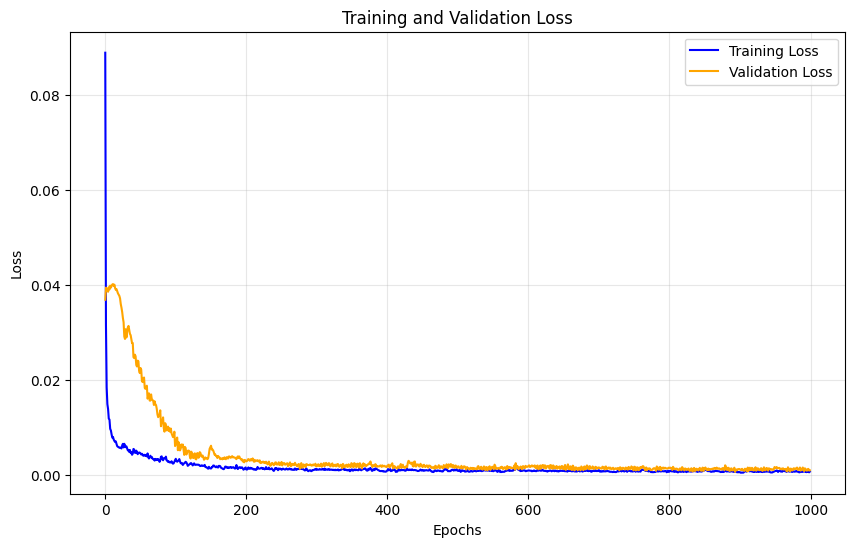

In [4]:
plot_loss(history)

# Prediction & Performance

In [5]:
# 2D Map 결과 도출을 위한 지도 파라미터 세팅
proj = '+proj=lcc +lat_1=30 +lat_2=60 +lon_1=126 +lat_0=38 +lon_0=126 +ellps=GRS80 +units=m'
atob = {
    0: 'G', 1: 'F', 2: 'K', 3: 'J', 4: 'E', 5: 'D',
    6: 'O', 7: 'C', 8: 'A', 9: 'Q', 10: 'P', 11: 'B',
    12: 'M', 13: 'L', 14: 'N', 15: 'I', 16: 'H'}
region_columns = {
    'A': 'Seoul City', 'B': 'Incheon City', 'C': 'Busan City', 'D': 'Daegu City',
    'E': 'Gwangju City', 'F': 'Gyeonggi-do', 'G': 'Gangwon-do', 'H': 'Chungbuk-do',
    'I': 'Chungnam-do', 'J': 'Gyeongbuk-do', 'K': 'Gyeongnam-do', 'L': 'Jeonbuk-do',
    'M': 'Jeonnam-do', 'N': 'Jeju-do', 'O': 'Daejeon City', 'P': 'Ulsan City', 'Q': 'Sejong City'}

def get_ctprvn_map() -> gpd.GeoDataFrame:
    path = '/home/user/workdir/CMAQ_Emulator/main/resources/geom/ctp_rvn.shp'
    ctprvn = gpd.GeoDataFrame.from_file(path, encoding='cp949')
    ctprvn.crs = 'EPSG:5179'
    return ctprvn

def get_base_raster(ctprvn:gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    points = [Point(i, j)
                for i in range(-180000, -180000 + 9000 * 67, 9000)
                for j in range(-585000, -585000 + 9000 * 82, 9000)]
    grid_data = gpd.GeoDataFrame(points, geometry='geometry', columns=['geometry'])
    grid_data.crs = ctprvn.to_crs(proj).crs
    grid_data.loc[:,'x_m'] = grid_data.geometry.x
    grid_data.loc[:,'y_m'] = grid_data.geometry.y
    grid_data.loc[:,'value'] = 0
    grid_data.loc[:,'index'] = grid_data.index
    return grid_data

def get_region_pixel_indices() -> list:
    ctprvn = get_ctprvn_map()
    grid_data = get_base_raster(ctprvn)

    cities = {
        0: '강원도', 1: '경기도', 2: '경상남도', 3: '경상북도',
        4: '광주광역시', 5: '대구광역시', 6: '대전광역시', 7: '부산광역시',
        8: '서울특별시', 9: '세종특별자치시', 10: '울산광역시', 11: '인천광역시',
        12: '전라남도', 13: '전라북도', 14: '제주특별자치도', 15: '충청남도',
        16: '충청북도'
    }

    gdf_joined_loc = ['CTPRVN_CD', 'CTP_ENG_NM', 'CTP_KOR_NM', 'index_right0']
    gdf_joined = gpd.sjoin(ctprvn, grid_data.to_crs(5179), predicate='contains')

    indices = gpd.GeoDataFrame(pd.merge(
        left=grid_data, right=gdf_joined.loc[:,gdf_joined_loc], 
        how='left', left_on='index', right_on='index_right0'
    ), geometry='geometry').dropna()
    pixel_indices = \
        [[(idx%82, idx//82) for idx in indices.loc[indices.CTP_KOR_NM==cities[region]].index.tolist()]
         for region, _ in cities.items()]
    return pixel_indices

ctprvn = get_ctprvn_map()
ctprvn_proj = ctprvn.to_crs(proj)

# 건국대(서울대)에서 제공한 대한민국 국토 grid 정보
grid_alloc = (
    pd.read_csv('/home/user/workdir/CMAQ_Emulator/main/resources/geom/grid_allocation.csv') # load grid allocation data
    .sort_values(by=['Row', 'Column', 'Ratio'], ascending=[True, True, False]) # sort by row, column, ratio
    .drop_duplicates(subset=['Row', 'Column'], keep='first') # drop duplicates
    .reset_index(drop=True) # reset index
)

# 정부에서 배포하는 대한민국 국토 grid 정보
pixel_indices = get_region_pixel_indices()
total_index = []
for idx, grids in enumerate(pixel_indices):
    for grid in grids:
        total_index.append([
            grid[1], grid[0], 100.0, atob[idx], region_columns[atob[idx]]
        ])
total_index = pd.DataFrame(total_index, columns=grid_alloc.columns)

# 두 기관에서 주는 grid에 한두픽셀씩 비어있는 부분이 있어, 두 기관 데이터를 모두 참조하여 중복되는 픽셀을 정리 후 최종 국토 grid 정보를 취득
grid_alloc = pd.concat([
    grid_alloc.drop(columns=['Ratio', 'Region_Name']),
    total_index.drop(columns=['Ratio', 'Region_Name'])
]).sort_values(by=['Region_Code']).drop_duplicates().reset_index(drop=True)
grid_alloc[['Row', 'Column']] = grid_alloc[['Row', 'Column']] - 1

row_indices, col_indices = zip(*grid_alloc[['Row', 'Column']].values)
offset_x, offset_y = 4500, 4500 # 지도 위치 맞추기

# 마스킹 처리
mask = np.zeros((82, 67))
mask[row_indices, col_indices] = 1

cmap_white = mpl.colormaps['jet']
cmap_white.set_under('white')

In [6]:
test_split = 0.4  # 테스트 데이터 비율 (20%)
random_seed = 42  # 랜덤 시드
model = tf.keras.models.load_model('/home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.2/final_model')

pred_emis_data = []

# Load Test Data
dataset_2013 = pd.read_csv('/home/user/workdir/CMAQ_Emulator/main/resources/ctrl/dataset_for_o3_v5.1.csv')
ctrl_data = pd.concat([dataset_2013], axis=0)
ctrl_data = ctrl_data.reset_index(drop=True).values
base_path_2013 = "/home/user/workdir/CMAQ_Emulator/main/datasets/concentration/2013"
conc_path = []
for i in range(1, 120): 
    conc_path.append(os.path.join(base_path_2013, '1.00', f'ACONC.{i}'))
conc_data = []
for path in conc_path:
    with nc.Dataset(path) as f:
        conc_data.append(f.variables['O3'][:].data.squeeze())  # ncf 파일 내 목적변수를 지정 
conc_data = np.array(conc_data).reshape(len(conc_path), 82, 67, 1)
    
pred_emis_data = ctrl_data[:, :17*5]

_, X_emis_test, _, y_test = train_test_split(pred_emis_data, conc_data, test_size=test_split, random_state=random_seed)

y_preds = model.predict([X_emis_test]) # 2가지 경계 조건에 따른 1년치 O3
y_pred = y_preds.squeeze()
y_true = y_test.squeeze()

2/2 [==============================] - 2s 488ms/step


In [7]:
mask_expanded = np.repeat(mask[np.newaxis, :, :], repeats=y_true.shape[0], axis=0) # (24, 82, 67)

pred_conc_map_w_lines = np.where(mask_expanded == 1, y_pred, 0)  # 마스킹 적용
true_conc_map_w_lines = np.where(mask_expanded == 1, y_true, 0) # 마스킹 적용
print(y_pred.shape)
print(y_true.shape)
print(pred_conc_map_w_lines.shape)
print(true_conc_map_w_lines.shape)

(48, 82, 67)
(48, 82, 67)
(48, 82, 67)
(48, 82, 67)


In [8]:
def plot_scatter(ax, y_true, y_pred):
    r_x, r_y = np.polyfit(y_true, y_pred, 1)
    ax.hist2d(
        y_true, y_pred,
        bins=150, cmap='jet', cmin=1,
        norm=mpl.colors.LogNorm(vmin=1, vmax=1000),
    )
    ax.plot(
        y_true, r_x*y_true + r_y,
        color='red', label=f"y={r_x:.4f}x+{r_y:.4f}")
    r2 = r2_score(y_true, y_pred)
    ax.text(
        0.05, 0.95, f"$R^2={r2:.4f}$ \nSlope={r_x:.4f}\nIntercept={r_y:.4f}",
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes, fontsize=11
    )
    ax.grid(alpha=0.25)
    return ax

def get_score(y_true, y_pred):
    batch_size = y_true.shape[0]
    y_true = y_true.reshape(batch_size, -1)
    y_pred = y_pred.reshape(batch_size, -1)
    y_norm_err = np.abs(y_true - y_pred) / np.mean(y_true, axis=1, keepdims=True)
    y_err_mean = np.mean(y_norm_err, axis=1)
    y_err_std = np.percentile(y_norm_err, q=5, axis=1)
    return y_err_mean, y_err_std

In [9]:
print(y_pred.shape)
print(y_true.shape)
print(pred_conc_map_w_lines.shape)
print(true_conc_map_w_lines.shape)

(48, 82, 67)
(48, 82, 67)
(48, 82, 67)
(48, 82, 67)


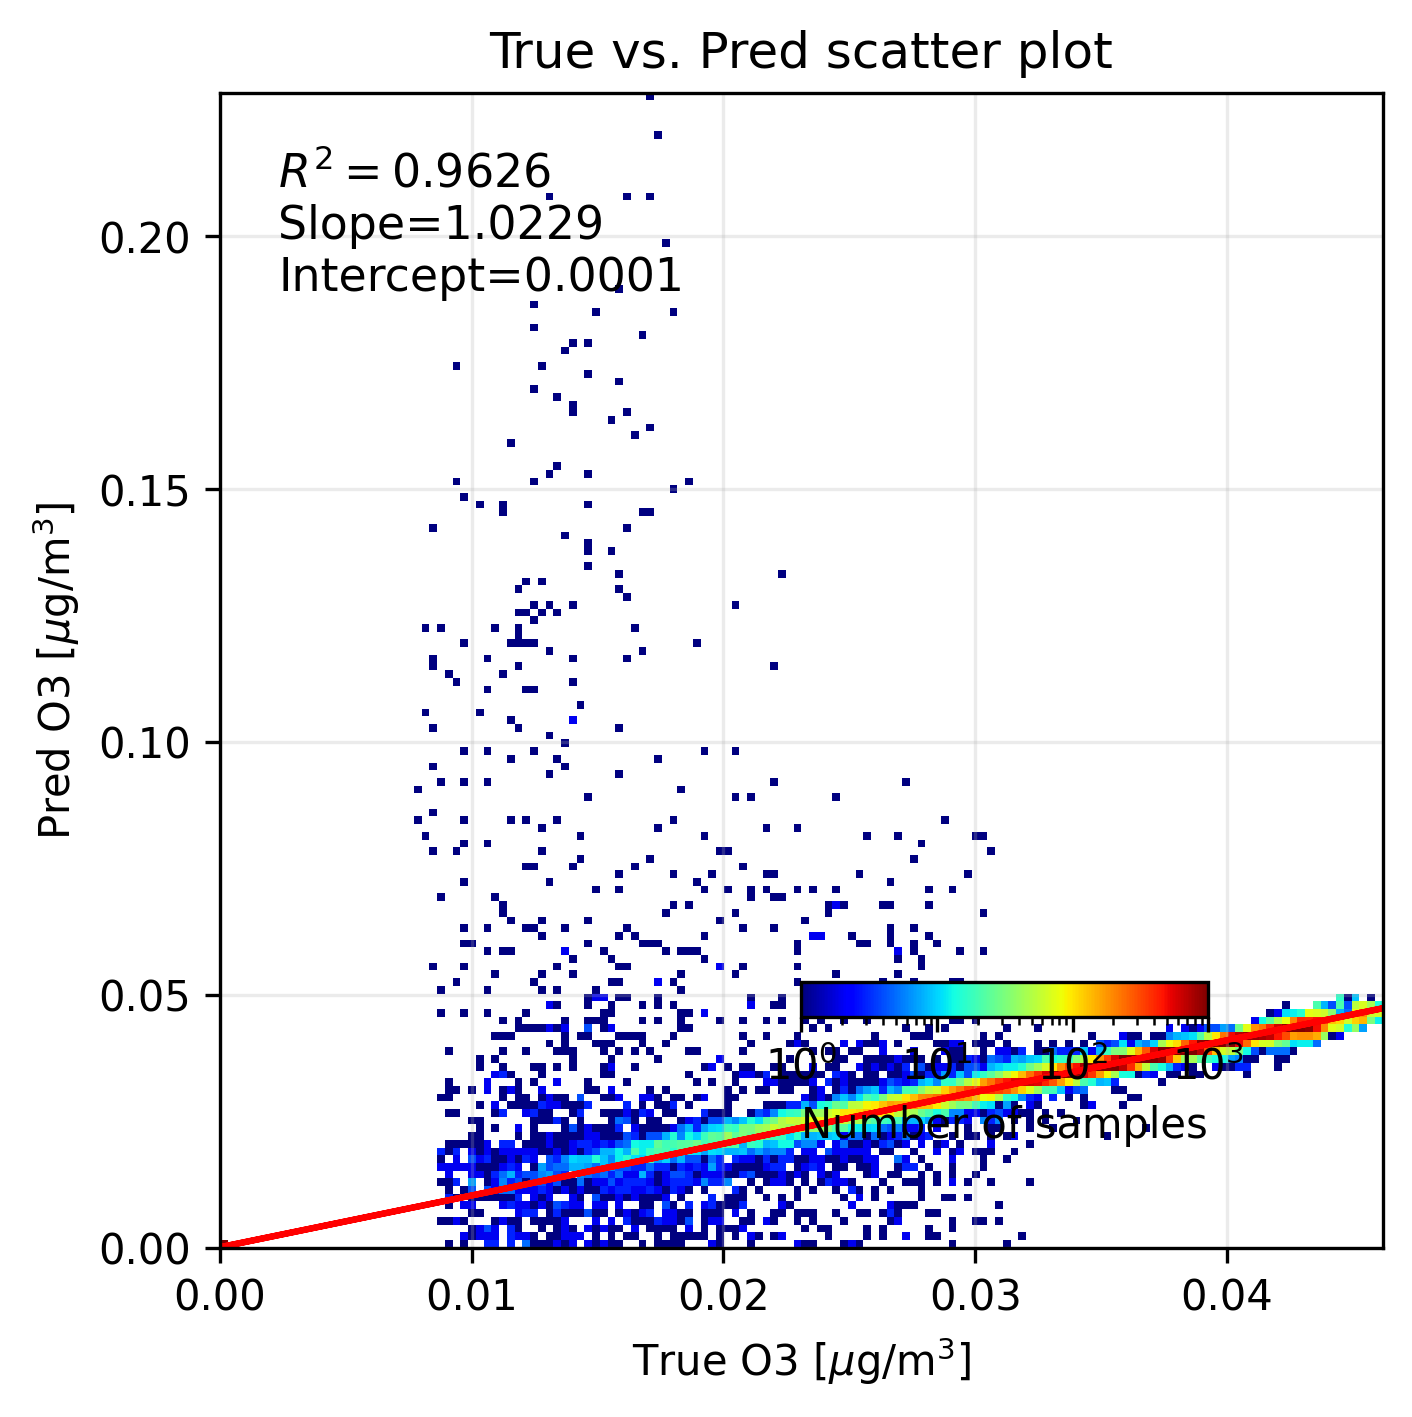

In [10]:
y_true_modi = true_conc_map_w_lines.reshape(-1)
y_pred_modi = pred_conc_map_w_lines.reshape(-1)

fig, axes = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
axes = plot_scatter(axes, y_true_modi, y_pred_modi)
axes.grid(alpha=0.25)
axes.set_title("True vs. Pred scatter plot")
axes.set_xlabel('True O3 [$\mu \mathrm{g}/\mathrm{m}^3$]')
axes.set_ylabel('Pred O3 [$\mu \mathrm{g}/\mathrm{m}^3$]')
cbaxes = axes.inset_axes([0.5, 0.2, 0.35, 0.03])
cb = plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.LogNorm(vmin=1, vmax=1000), cmap='jet'),
    cax=cbaxes, label='Number of samples', orientation='horizontal')
cb.set_label(label='Number of samples', fontsize=10)

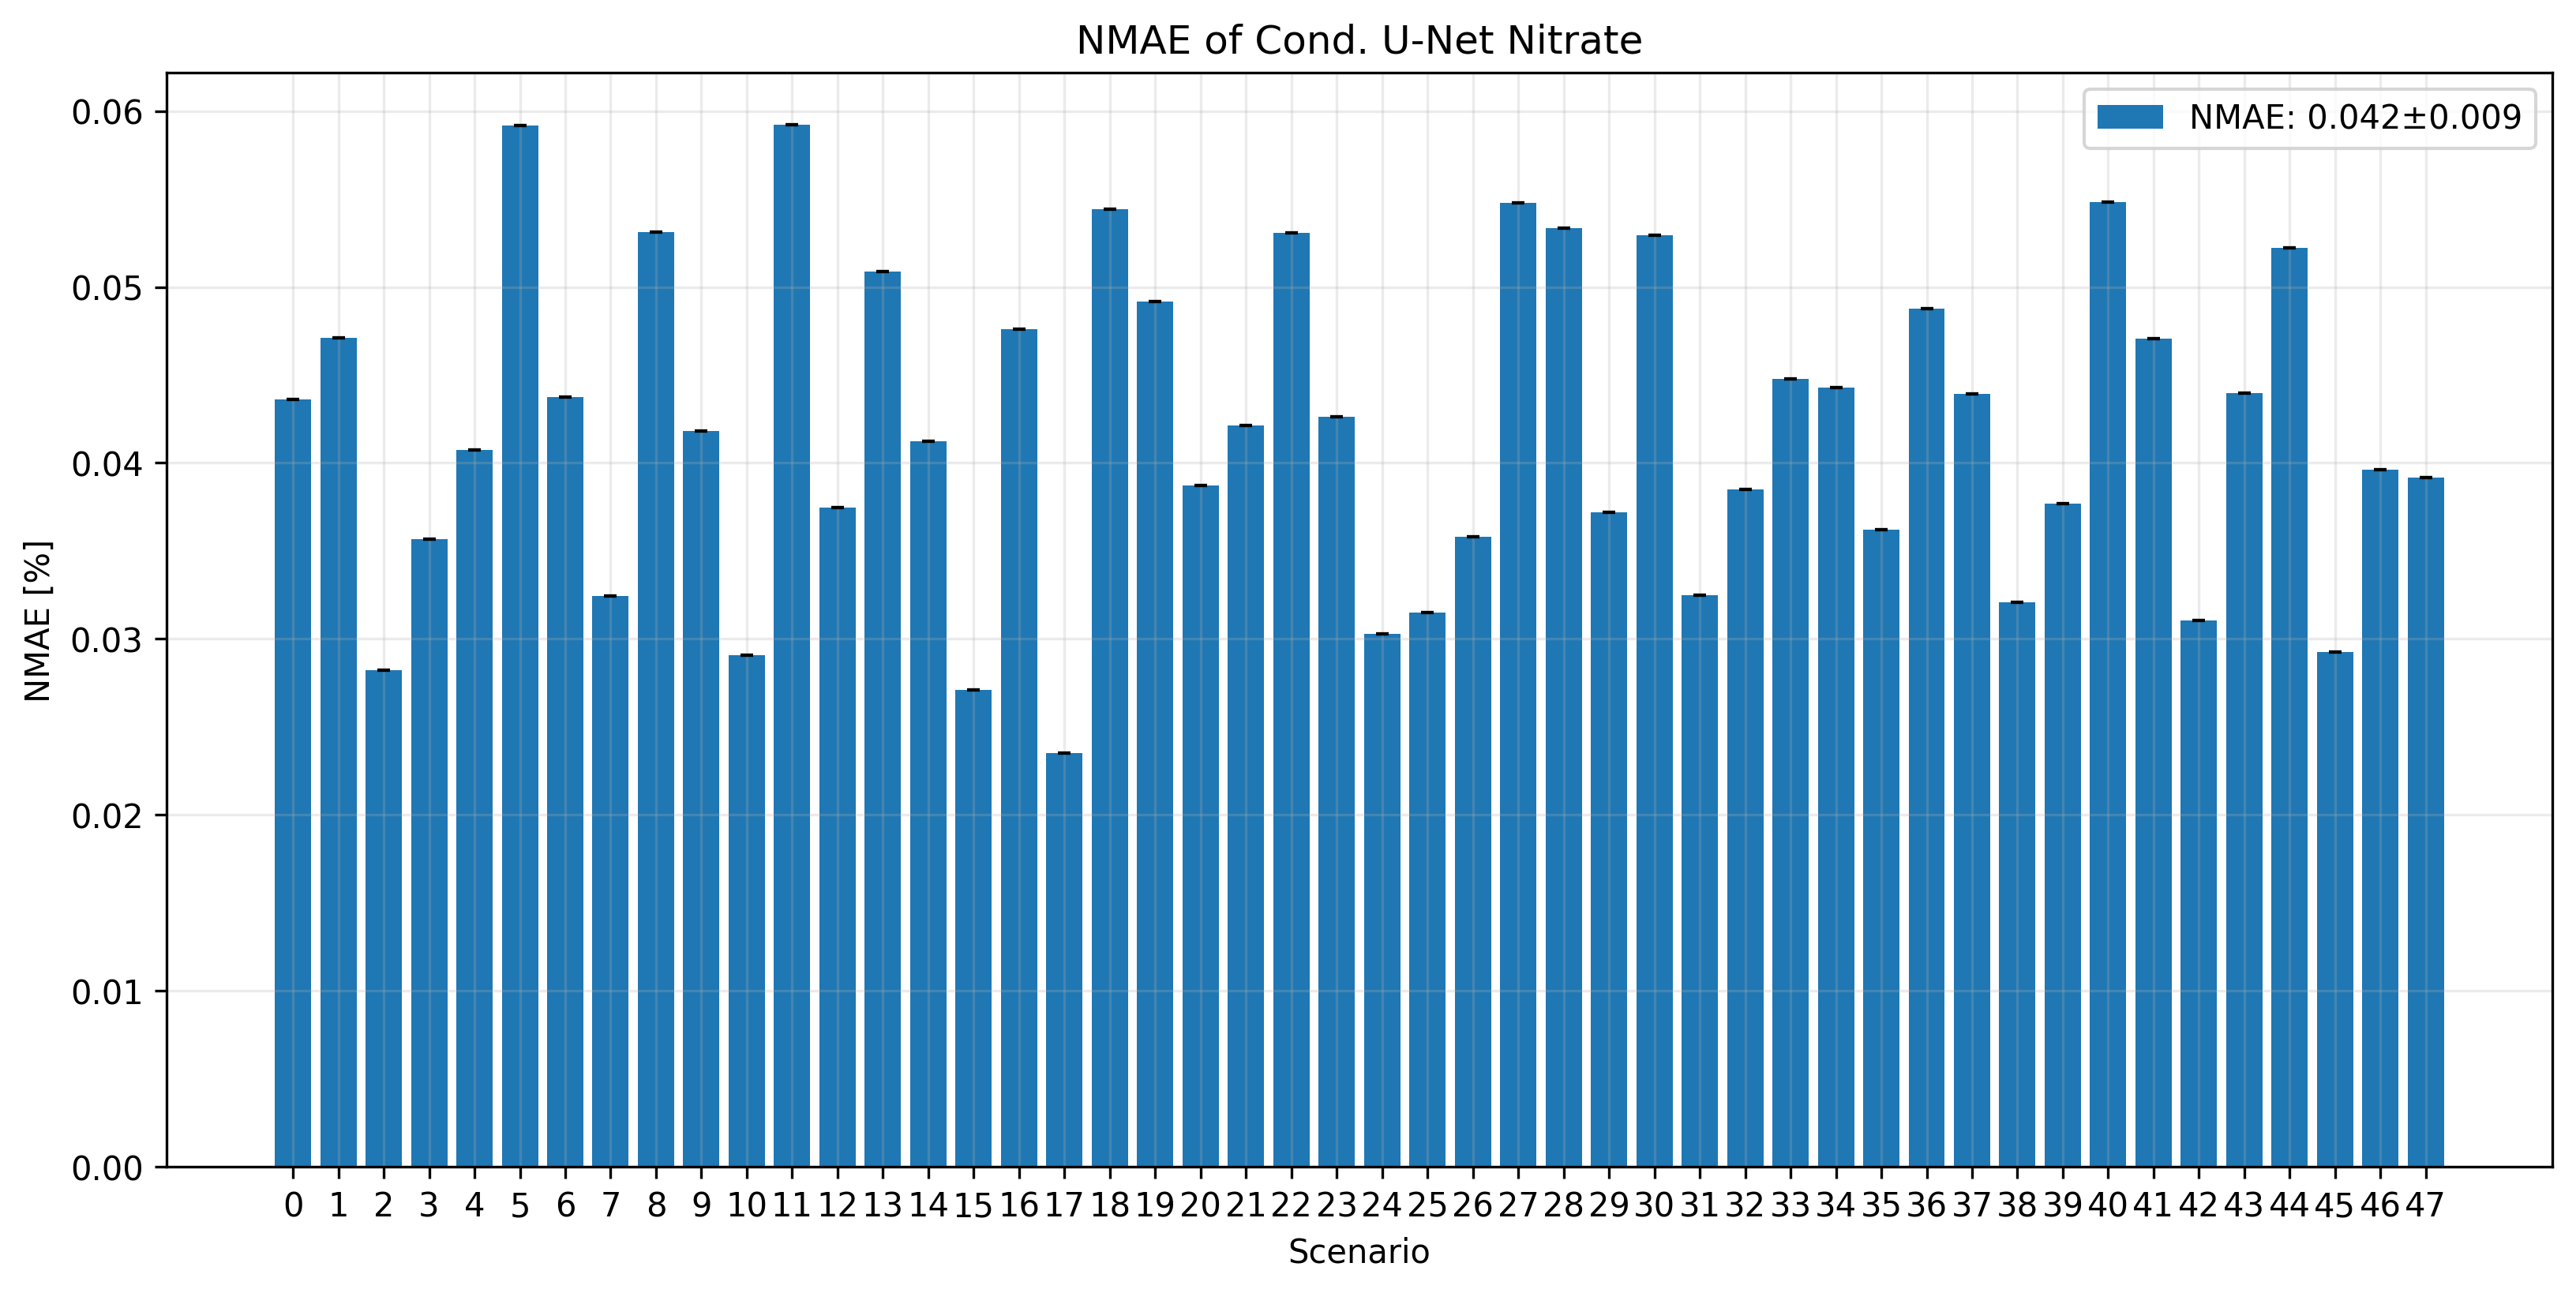

In [11]:
fig, axes = plt.subplots(1, 1, figsize=(13, 6), dpi=300)
score, score_std = get_score(true_conc_map_w_lines, pred_conc_map_w_lines)
label_text = f'NMAE: {np.mean(score):.3f}±{np.std(score):.3f}'

axes.bar(np.arange(y_test.shape[0]), score, yerr=score_std, label=label_text, capsize=2)
axes.set_xticks(np.arange(y_test.shape[0]), range(y_test.shape[0]))
axes.grid(alpha=0.25)
axes.legend()
axes.set_title("NMAE of Cond. U-Net Nitrate")
axes.set_xlabel('Scenario')
axes.set_ylabel('NMAE [%]')
plt.show()

In [12]:
# np.set_printoptions(threshold=sys.maxsize)
# print(true_conc_map_w_lines[17])

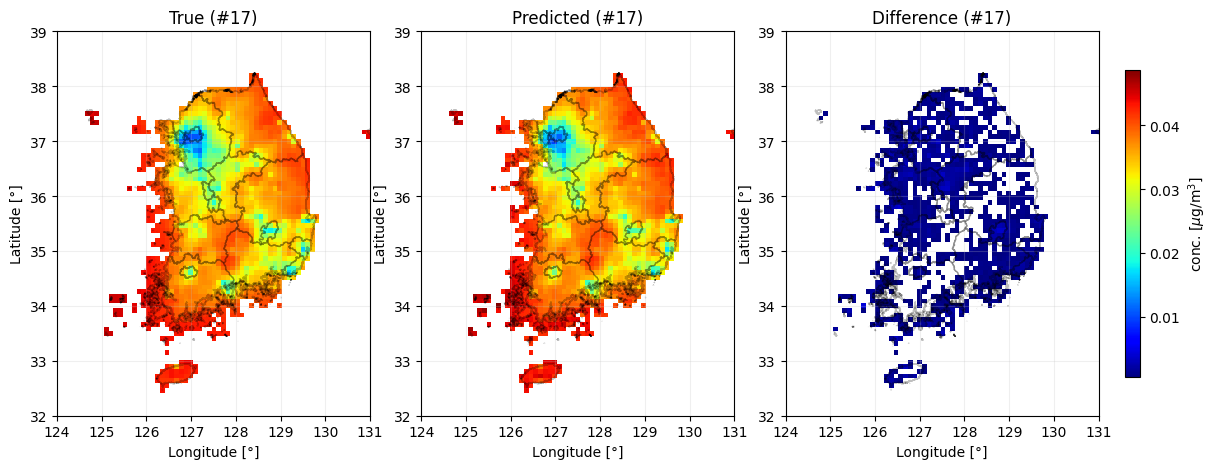

In [18]:
cmap_with_white = plt.get_cmap('jet').copy()   # 예: jet 컬러맵 복사
cmap_with_white.set_bad('white')               # 마스킹된 부분을 흰색으로

def plot_prediction_loss(y_true, y_pred, num_samples=1, indices=-1):
    if indices == -1 or indices < 0:
        indices = np.random.choice(len(y_true), num_samples, replace=False)
    else:
        index = indices
        indices = [index]
    
    # (예시) "선택된 인덱스들"만 고려한 local_min/local_max
    local_min = min(y_true[indices].min(), y_pred[indices].min())
    local_max = max(y_true[indices].max(), y_pred[indices].max())
    local_diff = np.abs(y_true[indices] - y_pred[indices])
    local_max = max(local_max, local_diff.max())

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    if num_samples == 1:
        axes = axes[np.newaxis, :]  # (1, 3) 형태로 맞춤

    # 지도 투영 좌표 범위
    x_min = -180000 + offset_x
    x_max =  414000 + offset_x
    y_min = -585000 + offset_y
    y_max =  144000 + offset_y

    x_ticks = np.linspace(x_min, x_max, 8)
    x_labels = [str(i) for i in range(124, 132)]
    y_ticks = np.linspace(y_min, y_max, 8)
    y_labels = [str(i) for i in range(32, 40)]

    # "0 이하이면 흰색"으로 표시하고 싶다면:
    threshold = 0.0005  # 또는 원하는 임계값(예: local_min 등)

    for i, idx in enumerate(indices):
        # (A) True 데이터
        data_true = y_true[idx][::-1]
        # 2) 마스킹: threshold 이하 부분을 마스크
        masked_true = np.ma.masked_where(data_true <= threshold, data_true)
        
        im_true = axes[i, 0].imshow(
            masked_true,
            cmap=cmap_with_white,          # 마스킹 컬러맵
            extent=(x_min, x_max, y_min, y_max),
            vmin=threshold,                # 컬러 스케일 최소
            vmax=local_max                 # 컬러 스케일 최대
        )
        ctprvn_proj.boundary.plot(
            ax=axes[i, 0], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25
        )
        axes[i, 0].set_title(f"True (#{idx})")
        axes[i, 0].set_xlabel('Longitude [°]')
        axes[i, 0].set_ylabel('Latitude [°]')
        axes[i, 0].set_xlim(x_min, x_max)
        axes[i, 0].set_ylim(y_min, y_max)
        axes[i, 0].set_xticks(x_ticks)
        axes[i, 0].set_yticks(y_ticks)
        axes[i, 0].set_xticklabels(x_labels)
        axes[i, 0].set_yticklabels(y_labels)
        axes[i, 0].grid(alpha=0.25, color='silver')

        # (B) Predicted
        data_pred = y_pred[idx][::-1]
        masked_pred = np.ma.masked_where(data_pred <= threshold, data_pred)

        im_pred = axes[i, 1].imshow(
            masked_pred,
            cmap=cmap_with_white,
            extent=(x_min, x_max, y_min, y_max),
            vmin=threshold,
            vmax=local_max
        )
        ctprvn_proj.boundary.plot(
            ax=axes[i, 1], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25
        )
        axes[i, 1].set_title(f"Predicted (#{idx})")
        axes[i, 1].set_xlabel('Longitude [°]')
        axes[i, 1].set_ylabel('Latitude [°]')
        axes[i, 1].set_xlim(x_min, x_max)
        axes[i, 1].set_ylim(y_min, y_max)
        axes[i, 1].set_xticks(x_ticks)
        axes[i, 1].set_yticks(y_ticks)
        axes[i, 1].set_xticklabels(x_labels)
        axes[i, 1].set_yticklabels(y_labels)
        axes[i, 1].grid(alpha=0.25, color='silver')

        # (C) Difference
        data_diff = np.abs(y_true[idx] - y_pred[idx])[::-1]
        masked_diff = np.ma.masked_where(data_diff <= threshold, data_diff)

        im_diff = axes[i, 2].imshow(
            masked_diff,
            cmap=cmap_with_white,
            extent=(x_min, x_max, y_min, y_max),
            vmin=threshold,
            vmax=local_max
        )
        ctprvn_proj.boundary.plot(
            ax=axes[i, 2], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25
        )
        axes[i, 2].set_title(f"Difference (#{idx})")
        axes[i, 2].set_xlabel('Longitude [°]')
        axes[i, 2].set_ylabel('Latitude [°]')
        axes[i, 2].set_xlim(x_min, x_max)
        axes[i, 2].set_ylim(y_min, y_max)
        axes[i, 2].set_xticks(x_ticks)
        axes[i, 2].set_yticks(y_ticks)
        axes[i, 2].set_xticklabels(x_labels)
        axes[i, 2].set_yticklabels(y_labels)
        axes[i, 2].grid(alpha=0.25, color='silver')

    # 서브플롯 간격/레이아웃 조정
    plt.subplots_adjust(wspace=-0.4, hspace=0.2)
    plt.tight_layout(rect=[0, 0, 0.88, 0.96])

    # (3) 단일 컬러바
    cbar = fig.colorbar(
        im_true,
        ax=axes.ravel().tolist(),
        orientation='vertical',
        fraction=0.03,
        pad=0.02,
        shrink=0.8
    )
    cbar.set_label('conc. [$\\mu \\mathrm{g}/\\mathrm{m}^3$]')

    plt.show()

# ==============================
plot_prediction_loss(true_conc_map_w_lines, pred_conc_map_w_lines, indices=17)

In [14]:
true_conc_map_w_lines_re = true_conc_map_w_lines
pred_conc_map_w_lines_re = pred_conc_map_w_lines

true_conc_map_w_lines_re = np.delete(true_conc_map_w_lines, 17, axis=0)
pred_conc_map_w_lines_re = np.delete(pred_conc_map_w_lines, 17, axis=0)

print(true_conc_map_w_lines_re.shape)
print(pred_conc_map_w_lines_re.shape)

(47, 82, 67)
(47, 82, 67)


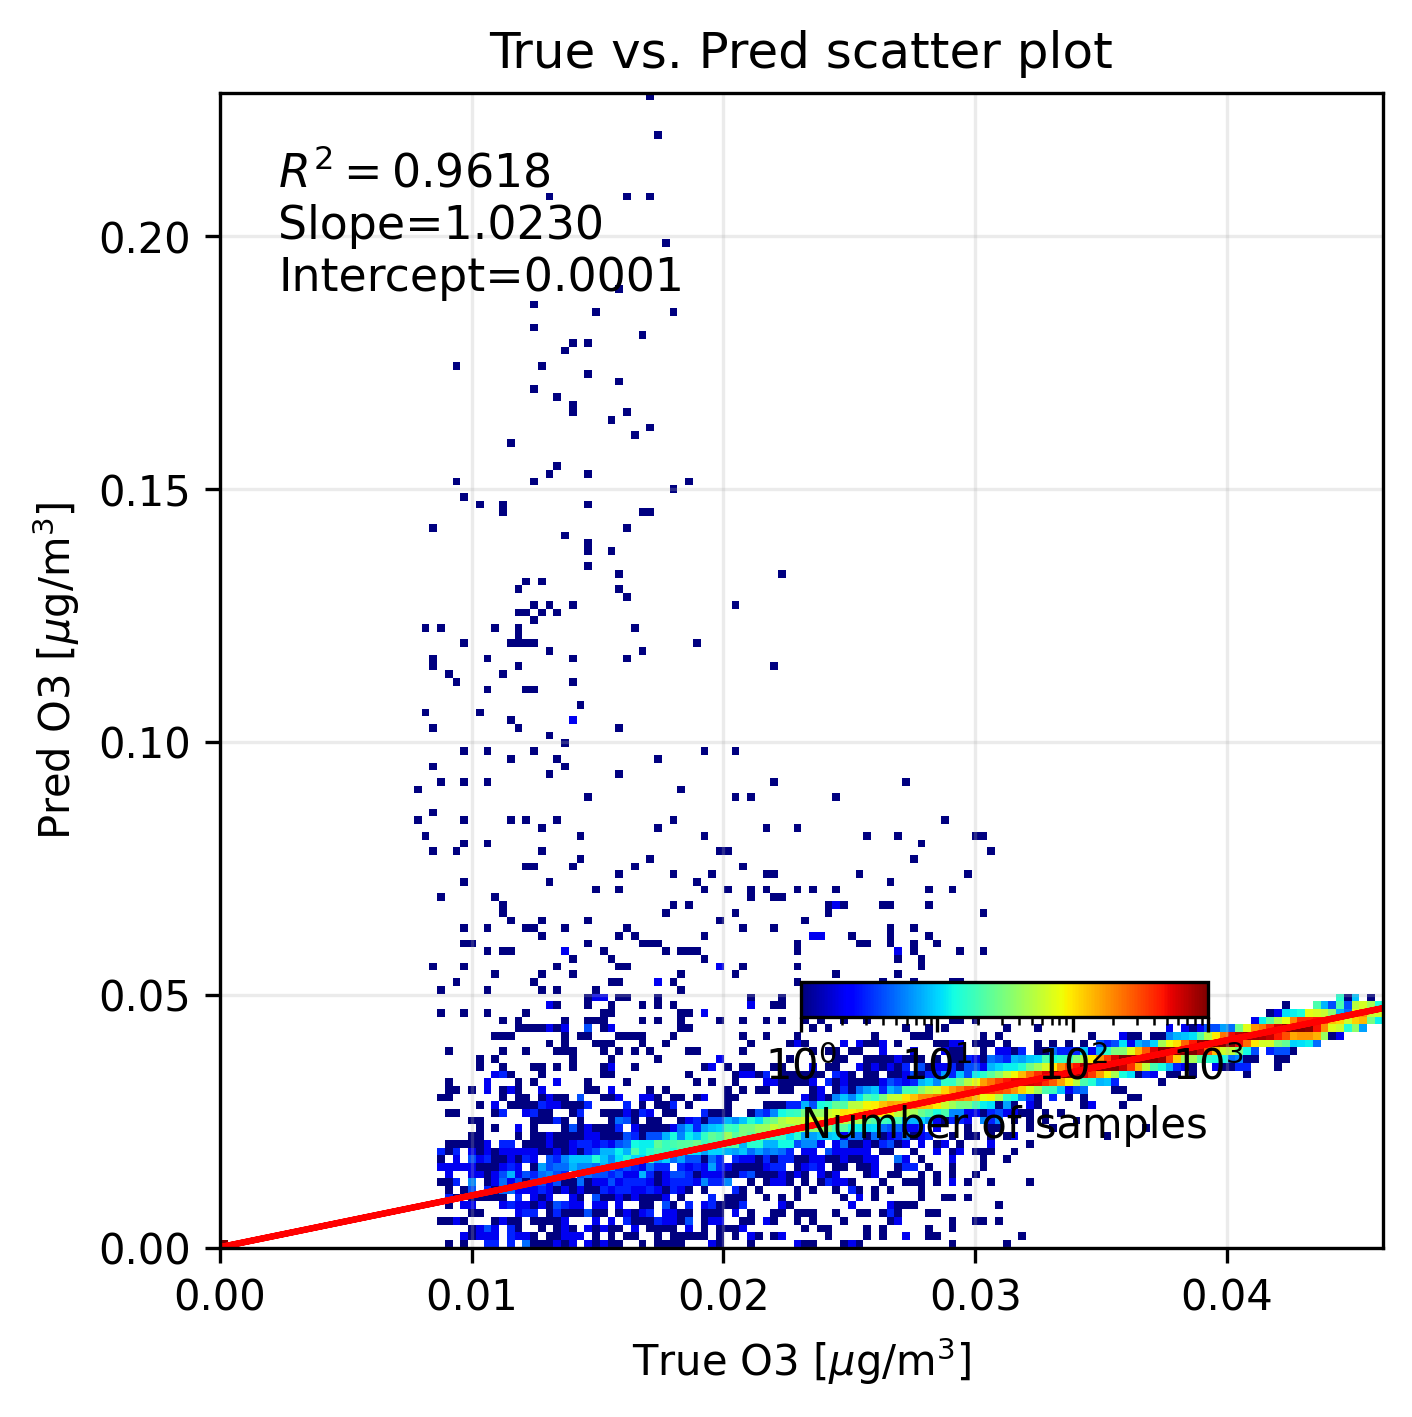

In [15]:
y_true_modi = true_conc_map_w_lines_re.reshape(-1)
y_pred_modi = pred_conc_map_w_lines_re.reshape(-1)

fig, axes = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
axes = plot_scatter(axes, y_true_modi, y_pred_modi)
axes.grid(alpha=0.25)
axes.set_title("True vs. Pred scatter plot")
axes.set_xlabel('True O3 [$\mu \mathrm{g}/\mathrm{m}^3$]')
axes.set_ylabel('Pred O3 [$\mu \mathrm{g}/\mathrm{m}^3$]')
cbaxes = axes.inset_axes([0.5, 0.2, 0.35, 0.03])
cb = plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.LogNorm(vmin=1, vmax=1000), cmap='jet'),
    cax=cbaxes, label='Number of samples', orientation='horizontal')
cb.set_label(label='Number of samples', fontsize=10)

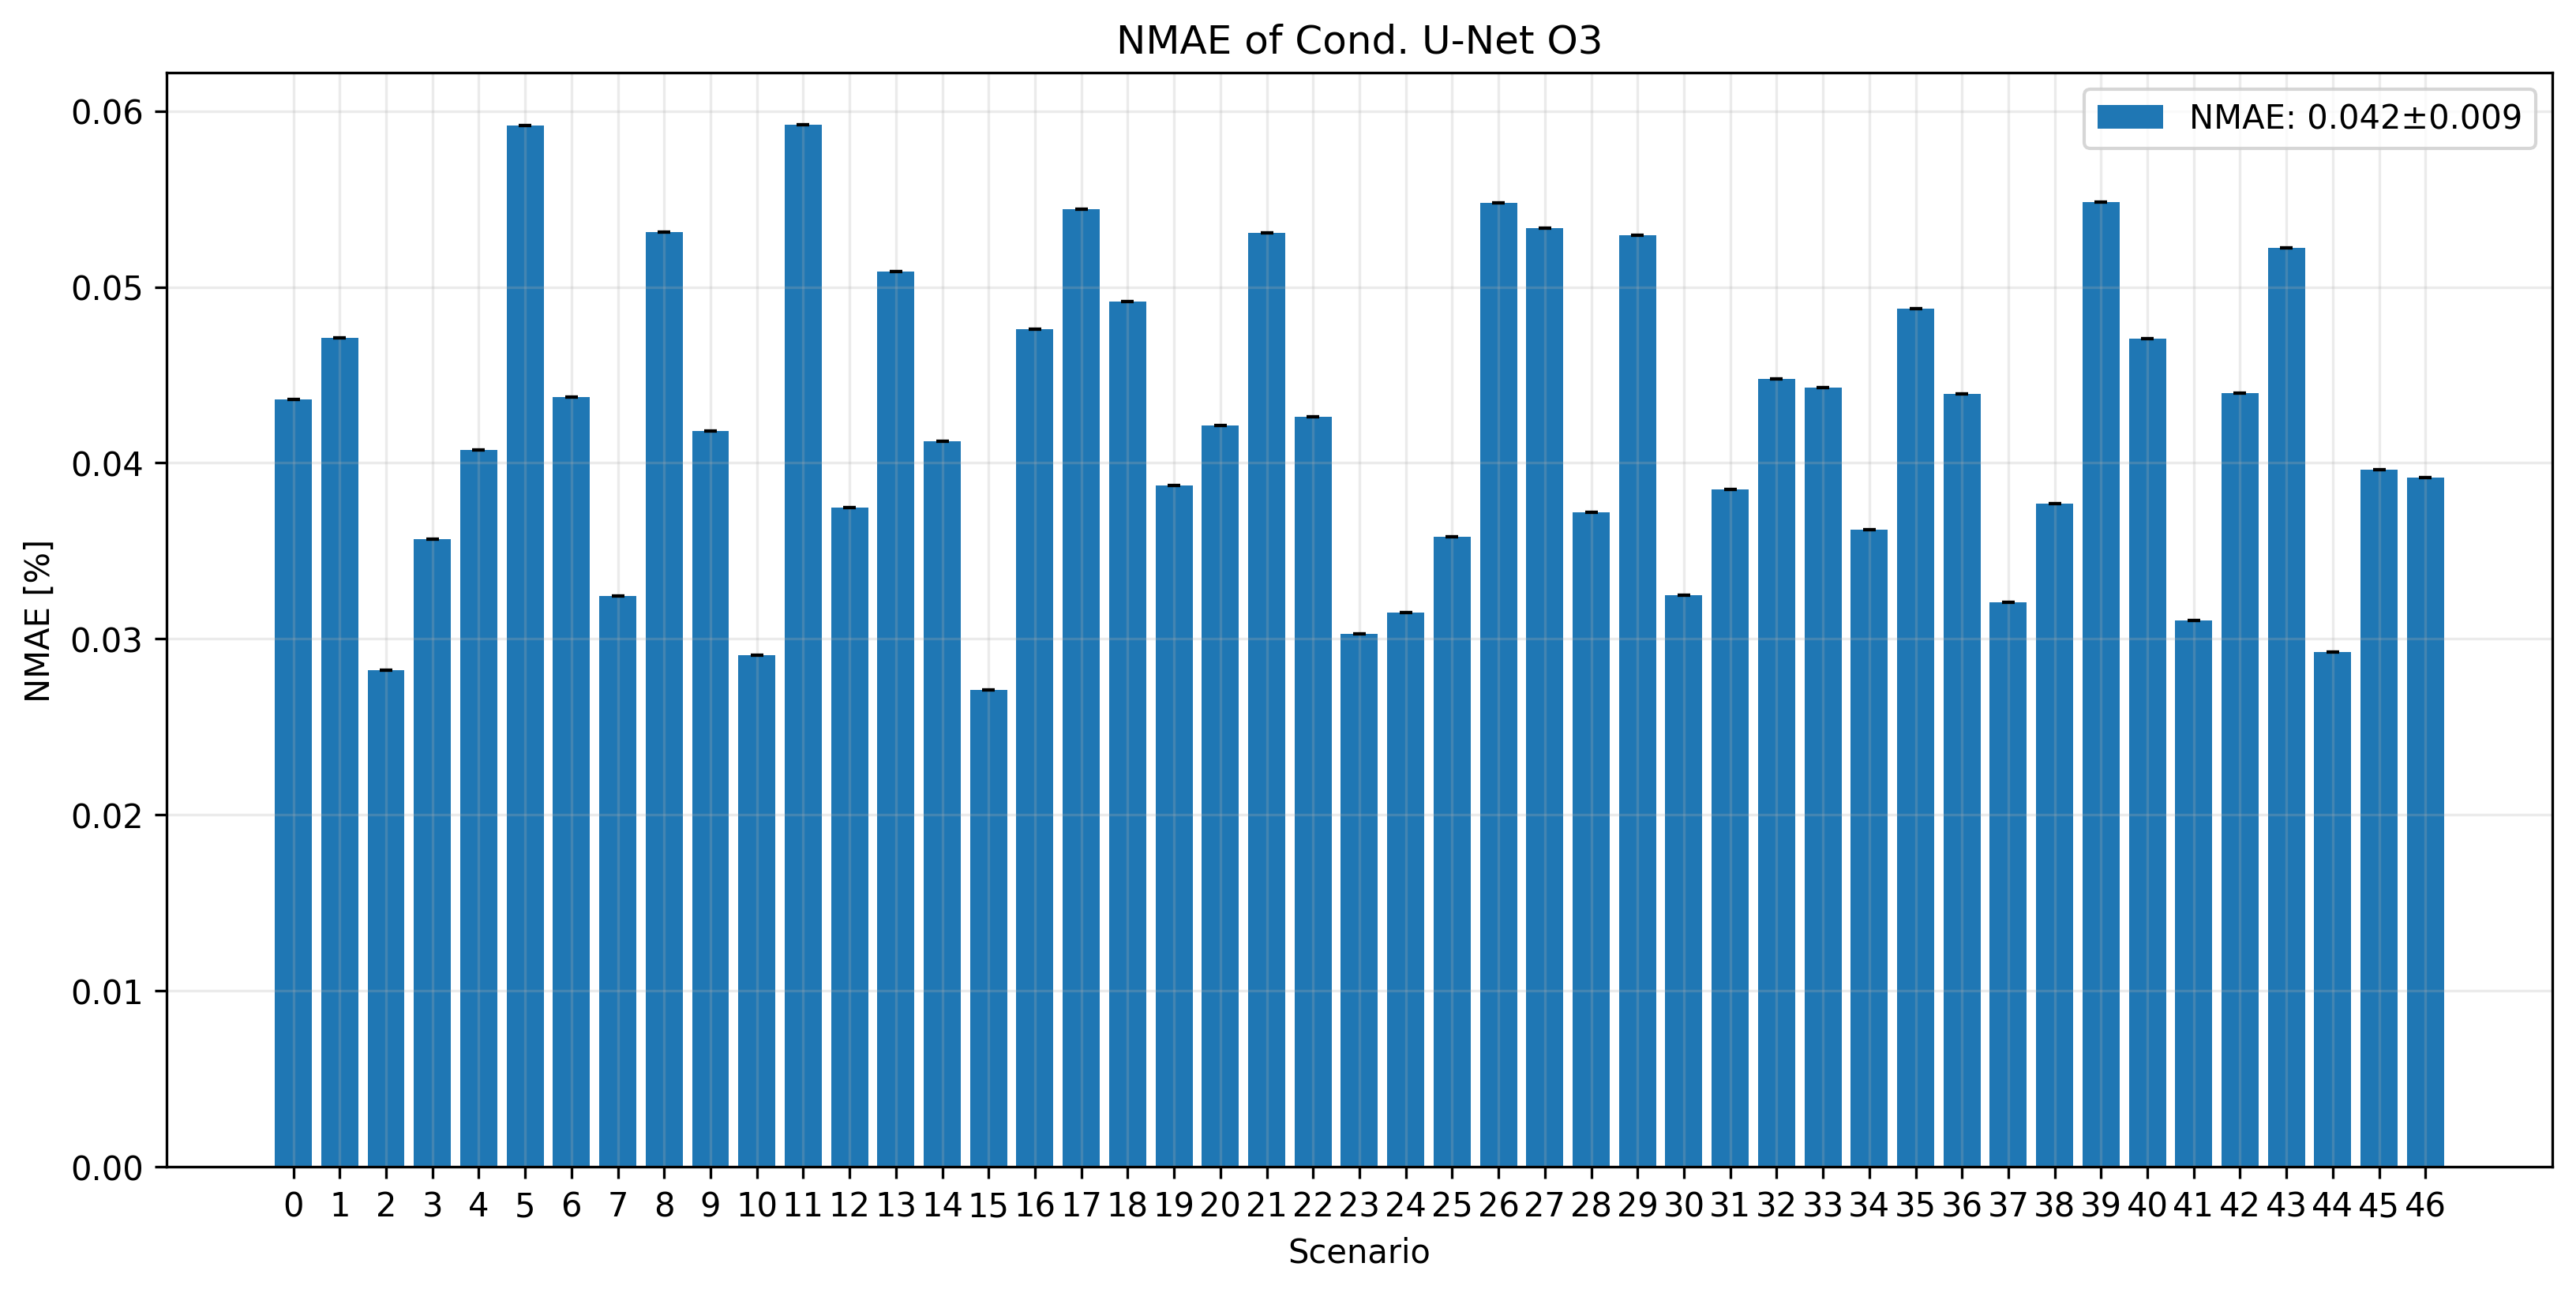

In [16]:
fig, axes = plt.subplots(1, 1, figsize=(13, 6), dpi=300)
score, score_std = get_score(true_conc_map_w_lines_re, pred_conc_map_w_lines_re)
label_text = f'NMAE: {np.mean(score):.3f}±{np.std(score):.3f}'

axes.bar(np.arange(y_test.shape[0]-1), score, yerr=score_std, label=label_text, capsize=2)
axes.set_xticks(np.arange(y_test.shape[0]-1), range(y_test.shape[0]-1))
axes.grid(alpha=0.25)
axes.legend()
axes.set_title("NMAE of Cond. U-Net O3")
axes.set_xlabel('Scenario')
axes.set_ylabel('NMAE [%]')
plt.show()